### Import libraries

In [74]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from pandas import DataFrame
from keras import Sequential
from statsmodels.tsa.seasonal import seasonal_decompose

### Utility functions 

In [75]:

def split_train_validate_test(df: DataFrame, train_percent=.6, validate_percent=.2, test_percent=.2):
    df.sort_values(by="Date", inplace=True) 
    m = len(df)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    
    train = df.iloc[:train_end]
    validate = df.iloc[train_end:validate_end]
    test = df.iloc[validate_end:]
    
    return train, validate, test

def plot_history(history):
    history_dict = history.history

    # MAE Plot
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 1, 1)
    plt.plot(history_dict['mae'], label='Training MAE')
    plt.plot(history_dict['val_mae'], label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('Training and Validation MAE')
    plt.legend()
    plt.grid(True)

    # MSE Plot
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history_dict['mse'], label='Training MSE')
    plt.plot(history_dict['val_mse'], label='Validation MSE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('Training and Validation MSE')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def load_data():
    df = pd.read_csv('./training_data/GBPUSD_open_5year.csv')
    df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")
    df.sort_values(by="Date", inplace=True)
    return df


def plot_gbp_usd(data):
    plt.figure(figsize=(14, 7))
    plt.title('GBPUSD Exchange Rate')
    plt.ylabel('Price GBP-USD')

    colors = plt.cm.tab10.colors  # Use a colormap for distinct colors

    # Iterate through each dataset in the array
    for idx, dataset in enumerate(data):
        dates = dataset[0]
        prices = dataset[1]
        label = data[idx][2]
        plt.plot(dates, prices, label=f'{label}', color=colors[idx % len(colors)], alpha=0.7, linewidth=2 if 'actual' in label.lower() else 1)

    plt.xticks(pd.date_range(start=min(dates), end=max(dates), freq='3MS'), rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()

def pre_process_data(df: DataFrame):
    # Decompose the 'Open' column into trend, seasonality, and noise
    decomp = seasonal_decompose(df["Open"], model='additive', period=30)
    df["Trend"] = decomp.trend.bfill().ffill()
    df["Seasonality"] = decomp.seasonal.bfill().ffill()
    df["Noise"] = decomp.resid.bfill().ffill()

    # Extract temporal features
    df["Week"] = df["Date"].dt.isocalendar().week
    df["Month"] = df["Date"].dt.month
    df["Day"] = df["Date"].dt.day
    return df

def plot_pre_processed_data(df: DataFrame):
    plt.figure(figsize=(14, 10))

    plt.subplot(4, 1, 1)
    plt.plot(df["Date"], df["Open"], label="Original", color="blue")
    plt.title("Original Data")
    plt.legend()

    plt.subplot(4, 1, 2)
    plt.plot(df["Date"], df["Trend"], label="Trend", color="orange")
    plt.title("Trend")
    plt.legend()

    plt.subplot(4, 1, 3)
    plt.plot(df["Date"], df["Seasonality"], label="Seasonality", color="green")
    plt.title("Seasonality")
    plt.legend()

    plt.subplot(4, 1, 4)
    plt.plot(df["Date"], df["Noise"], label="Noise", color="red")
    plt.title("Noise")
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_train_val_evaluation_history(t, v, type="MAE"):
    plt.figure(figsize=(12, 6))
    plt.plot(t, label=f'Training {type}', color='blue')
    plt.plot(v, label=f'Validation {type}', color='orange')
    plt.title(f"Training and Validation {type}")
    plt.xlabel('Epochs')
    plt.ylabel(f'Mean {"Absolute" if type == "MAE" else "Squared"} Error ({type})')
    plt.legend()
    plt.grid(True)
    plt.show()

def print_evaluation_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true.values - y_pred.flatten()) / y_true.values)) * 100
    print(f"Mean Absolute Error (MAE): {mae:.3f}")
    print(f"Mean Squared Error (MSE): {mse:.3f}")
    print(f"R^2 Score: {r2:.3f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.3f}%")
    return {"MAE": mae, "MSE": mse, "R Square": r2, "MAPE": mape}

def time_sequence_generator(feature, target, time_step):
    X = []
    y = []
    # Iterate over data to create sequences
    for i in range(time_step, len(feature)):
        X.append(feature[i - time_step:i])  
        y.append(target[i])  
    
    return np.array(X), np.array(y)

# 1. Visualize the data

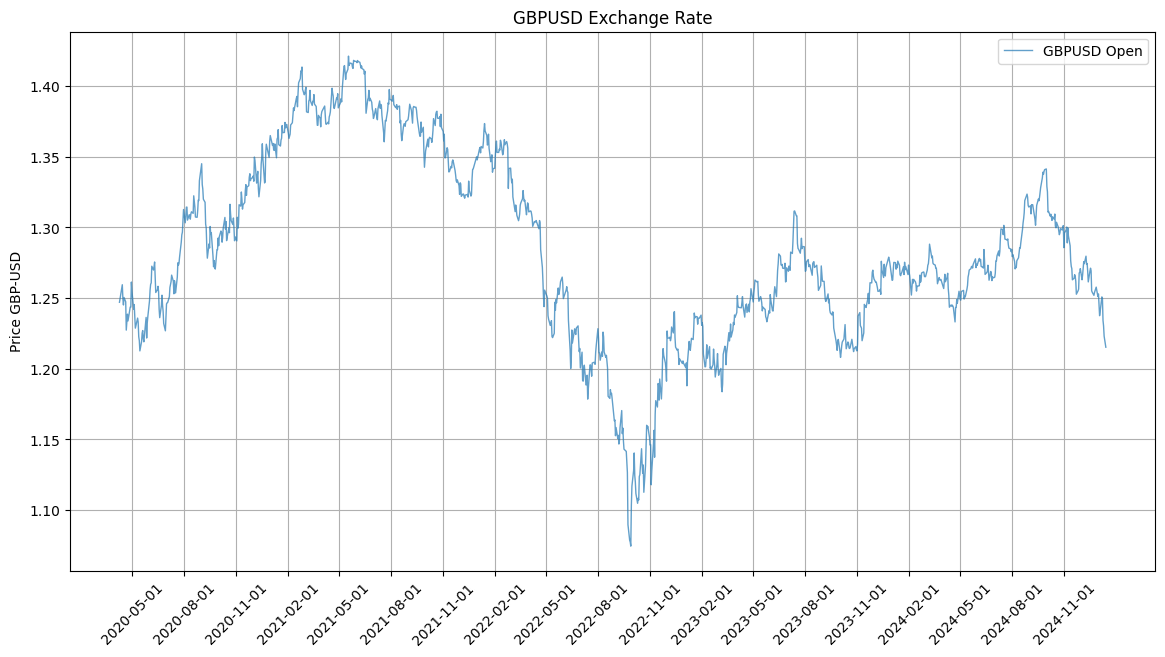

In [76]:
data = load_data()
plot_gbp_usd([[data['Date'], data['Open'], "GBPUSD Open"]])

# 2. Pre-process the data
Dissect temporal information like Trend, Seasonality, Noise, Day, Week & Month   

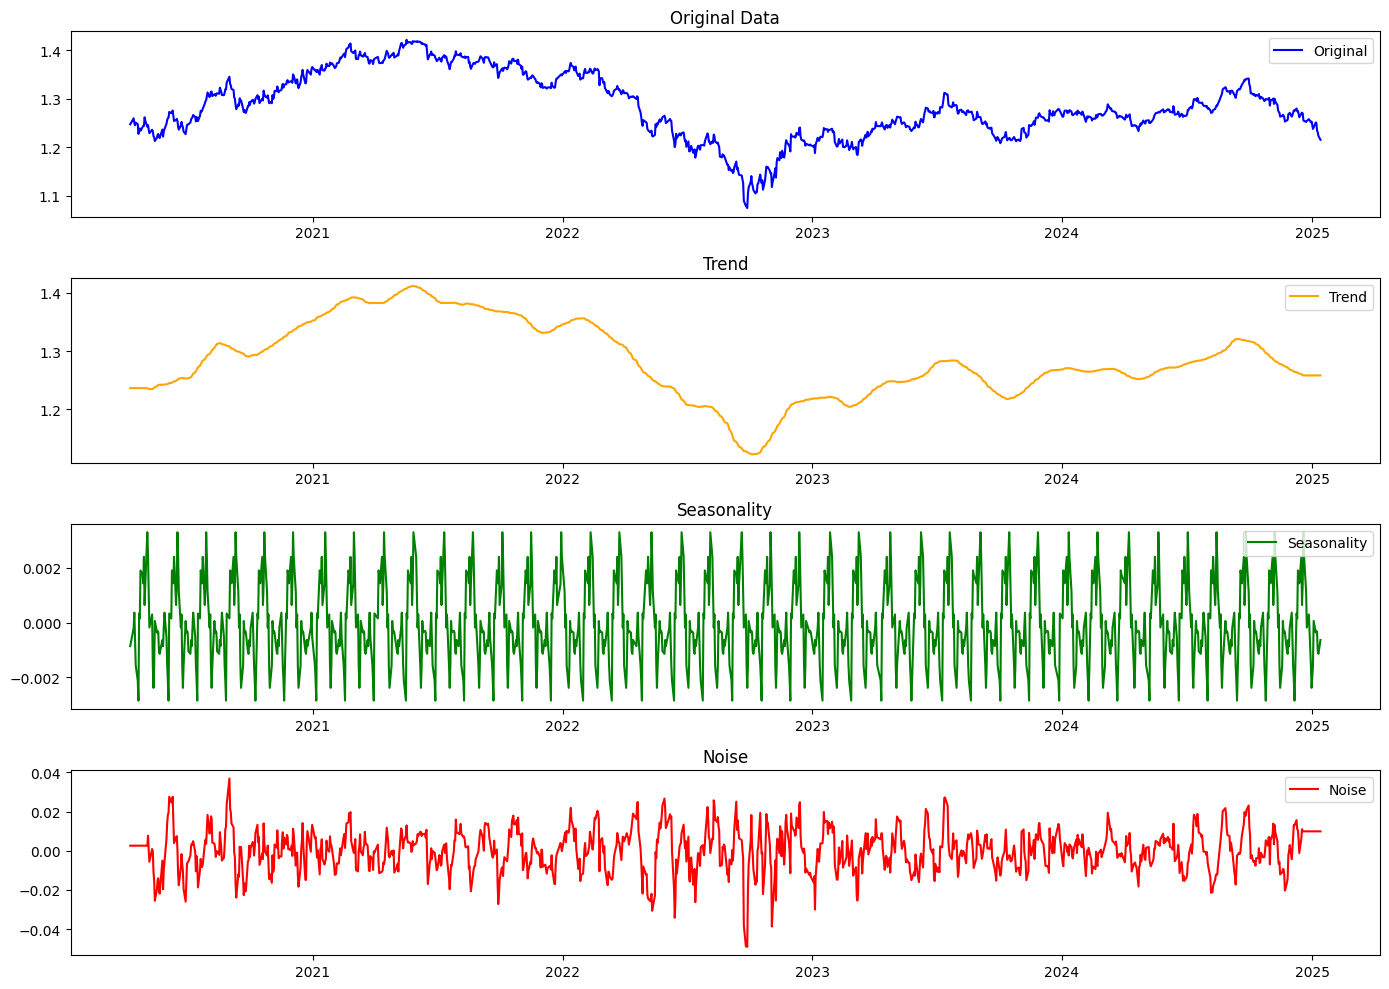

In [40]:
# General pre-process data for overall models
df = load_data()
df = pre_process_data(df)
plot_pre_processed_data(df)


# 3. Model based on each time instance (DNN)

### 3.1 Split the Test, validate and Train data 


In [41]:
# Training  and Target Features
features = ['Trend', 'Seasonality', 'Noise', 'Week', 'Month', 'Day']
target = "Open"

# Split data 
u_train, u_validate, u_test = split_train_validate_test(df, train_percent=.7, validate_percent=0.15, test_percent=.15)

### 3.2 Scale the features and target

In [42]:
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Scale train, validate, and test sets
# Feature and target scaling on Training data 
train = pd.DataFrame()
feature_scaler.fit_transform(u_train[features])
target_scaler.fit_transform(u_train[[target]])

train['Date'] = u_train['Date']
train[features] = feature_scaler.transform(u_train[features])
train[target] = target_scaler.transform(u_train[[target]])

validate = pd.DataFrame()
validate['Date'] = u_validate['Date']
validate[features] = feature_scaler.transform(u_validate[features])
validate[target] = target_scaler.transform(u_validate[[target]])

test = pd.DataFrame()
test['Date'] = u_test['Date']
test[features] = feature_scaler.transform(u_test[features])
test[target] = target_scaler.transform(u_test[[target]])


### 3.3 Develop a base model

In [78]:
base_dnn_model = Sequential([
	layers.Dense(64, activation='relu', input_shape=(len(features),)),
	layers.Dense(1)  
])

base_dnn_model.compile(optimizer='adam', loss='mae', metrics=['mae', 'mse'])
base_dnn_history = base_dnn_model.fit(train[features], train[target], epochs=10, batch_size=1, validation_data=(validate[features], validate[target]), verbose=0)
base_dnn_model.summary()


/Users/mac/Desktop/kingston/Deep-learning-assignment/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,733 (6.77 KB)

 Trainable params: 577 (2.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,156 (4.52 KB)

### 3.4 Base model evaluation 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


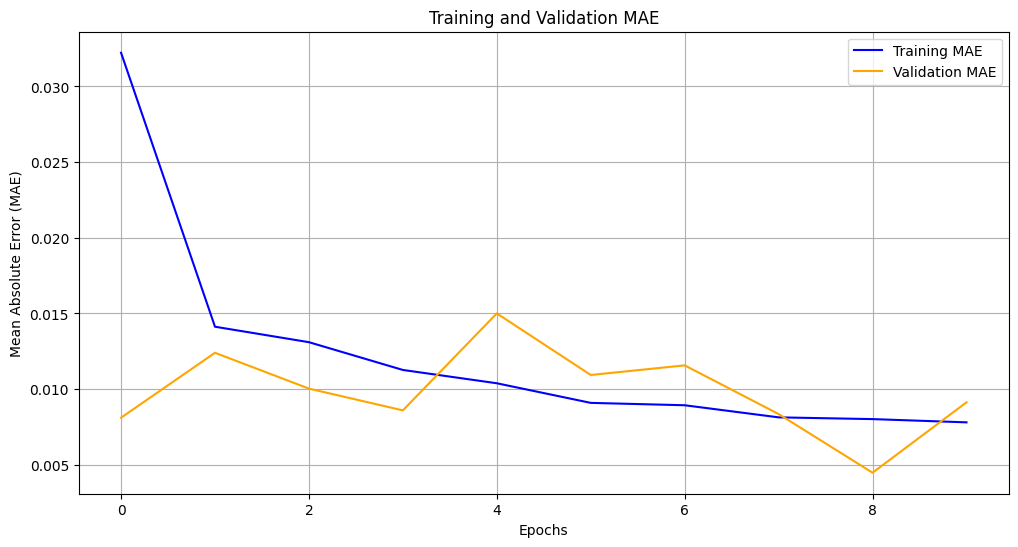

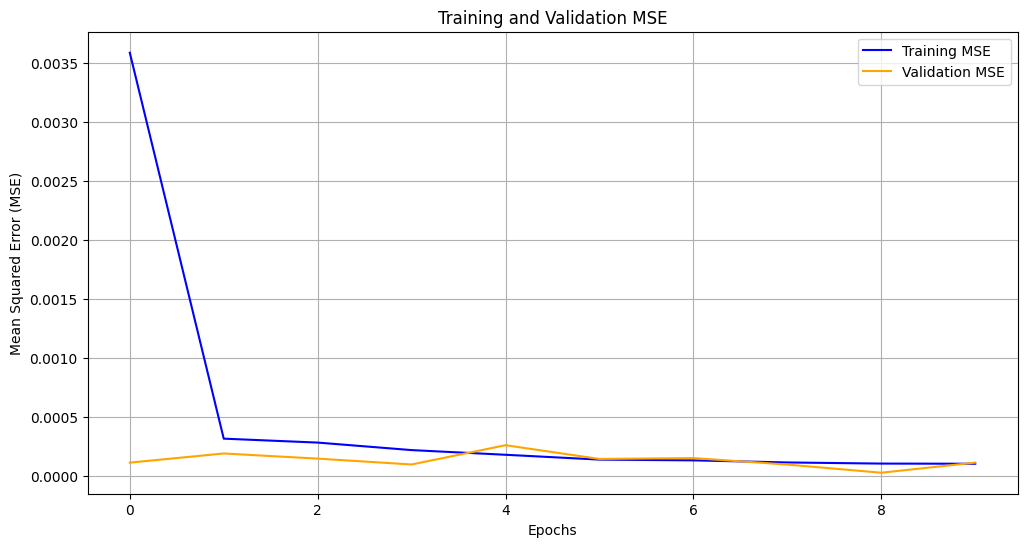

Mean Absolute Error (MAE): 0.011
Mean Squared Error (MSE): 0.000
R^2 Score: 0.937
Mean Absolute Percentage Error (MAPE): 12.917%


In [87]:
history = base_dnn_history.history

train_mae, train_mse = history['mae'], history['mse']
validate_mae, validate_mse = history['val_mae'], history['val_mse']

# Inverse transform before evaluation
y_true_orig = target_scaler.inverse_transform(train[[target]])
y_pred_orig = target_scaler.inverse_transform(base_dnn_model.predict(train[features]))
y_pred = base_dnn_model.predict(test[features])

plot_train_val_evaluation_history(train_mae, validate_mae, "MAE")
plot_train_val_evaluation_history(train_mse, validate_mse, "MSE")

dnn_base_metric = print_evaluation_metrics(test[[target]], y_pred)
            


### 3.5 Hyper-tuning

In [45]:
def build_model(hp):
    model = Sequential()
    num_layers_params = hp.Int('num_layers', 2, 4, step=5)

    i = 0
    unit_params = hp.Int(f'units_{i}', min_value=64, max_value=128, step=32)
    model.add(layers.Dense(units=unit_params, activation="relu", input_dim=len(features)))
    for i in range(1, num_layers_params):  
        model.add(layers.Dense(units=unit_params, activation='relu'))

    model.add(layers.Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

    return model

tuner = kt.Hyperband(build_model, objective='val_mse', factor=3, directory='nn_cache', project_name='DNN_tuning')
tuner.search(train[features],train[target],  epochs=50, validation_data=(validate[features], validate[target]), verbose=1)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Reloading Tuner from nn_cache/DNN_tuning/tuner0.json


### 3.6 Build Hyper-tuned model

In [46]:
dnn_model = build_model(best_hps)
history = dnn_model.fit(train[features], train[target], epochs=10, validation_data=(validate[features], validate[target]))
dnn_model.summary()

Epoch 1/10


/Users/mac/Desktop/kingston/Deep-learning-assignment/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1247 - mae: 0.2865 - mse: 0.1247 - val_loss: 0.0041 - val_mae: 0.0517 - val_mse: 0.0041
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0117 - mae: 0.0834 - mse: 0.0117 - val_loss: 0.0018 - val_mae: 0.0338 - val_mse: 0.0018
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 - mae: 0.0301 - mse: 0.0016 - val_loss: 2.9896e-04 - val_mae: 0.0126 - val_mse: 2.9896e-04
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7946e-04 - mae: 0.0154 - mse: 4.7946e-04 - val_loss: 3.0349e-04 - val_mae: 0.0142 - val_mse: 3.0349e-04
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1228e-04 - mae: 0.0148 - mse: 4.1228e-04 - val_loss: 2.7107e-04 - val_mae: 0.0133 - val_mse: 2.7107e-04
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4635e-04 - mae: 0.0116 - mse: 2.4635e-04 - val_loss: 1.6017e-04 - val_mae: 0.0103 - val_mse: 1.6017e-04
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7029e-0

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                │ (None, 96)             │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,245 (118.15 KB)

 Trainable params: 10,081 (39.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,164 (78.77 KB)

### 3.6 Evaluate hyper-tuned model 

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


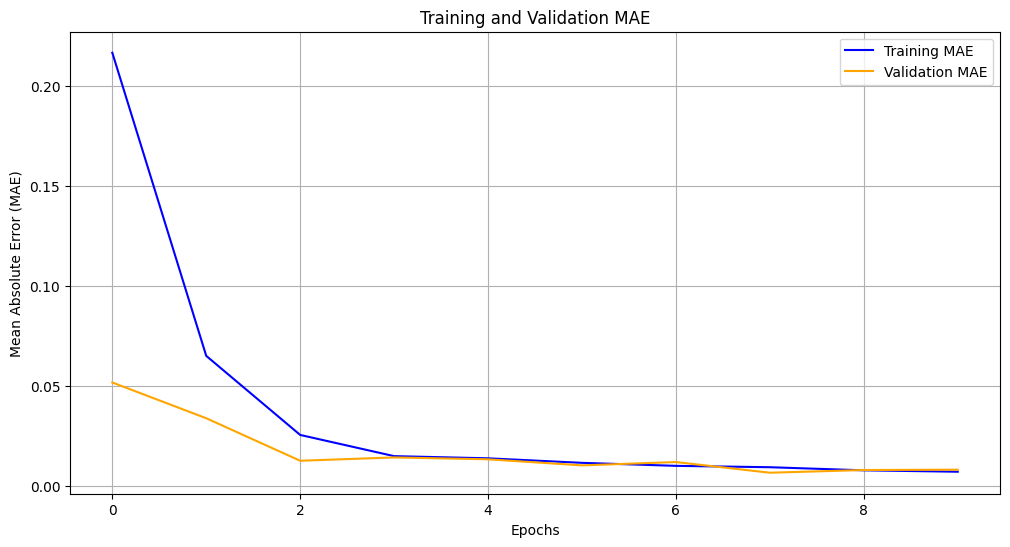

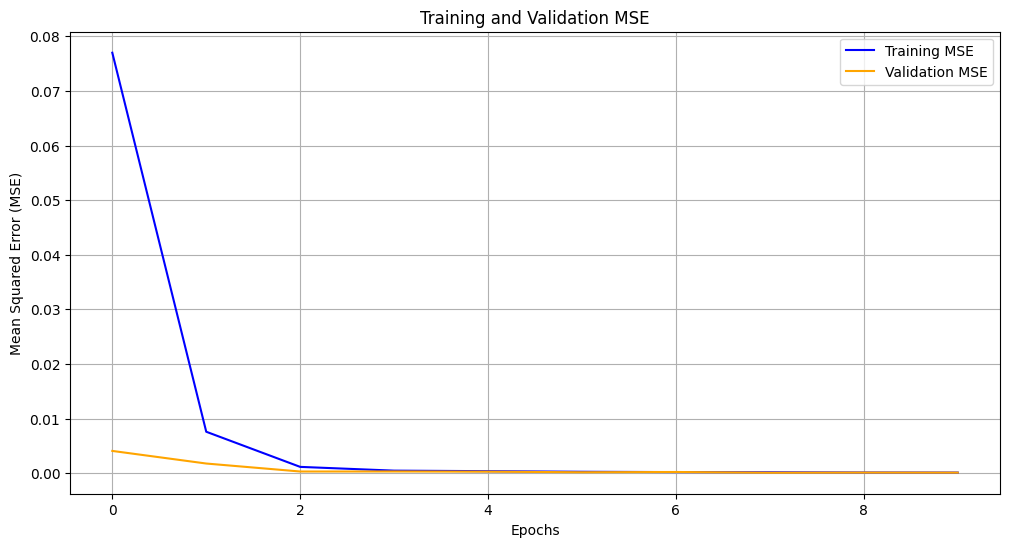

Mean Absolute Error (MAE): 0.011
Mean Squared Error (MSE): 0.001
R^2 Score: 0.865
Mean Absolute Percentage Error (MAPE): 2.151%


In [47]:
# Extract training and validation metrics
train_mae = history.history['mae']
train_mse = history.history['mse']
val_mae = history.history['val_mae']
val_mse = history.history['val_mse']

# Get model predictions on Test Data
y_pred = base_dnn_model.predict(test[features])
y_true = test[target]

# Plot the training and validation MAE and MSE 
plot_train_val_evaluation_history(train_mae, val_mae, "MAE")
plot_train_val_evaluation_history(train_mse, val_mse, "MSE")

# Print Evaluation Metrics
dnn_metric =  print_evaluation_metrics(y_true, y_pred)


### 3.7 Overview of whole predicted model 

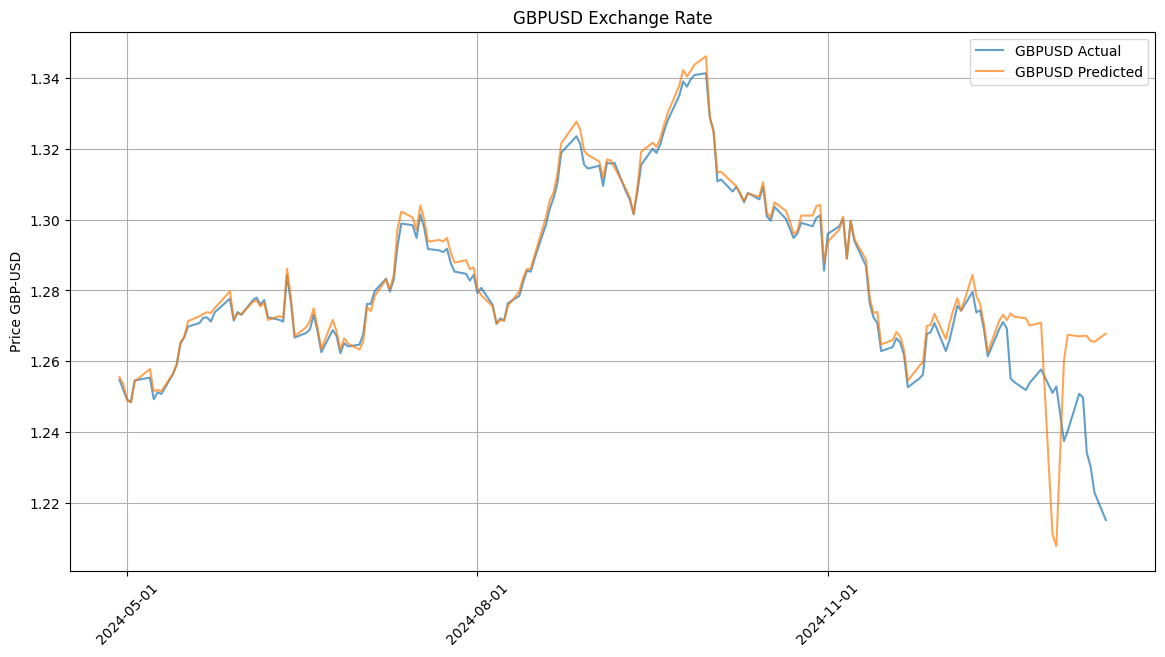

In [48]:
y_pred_unscaled = target_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))
y_test_unscaled = u_test[target].values

actual_data = [test["Date"], y_test_unscaled, "GBPUSD Actual"]
predicted_data = [test["Date"], y_pred_unscaled, "GBPUSD Predicted"]

dnn_predicted = y_pred_unscaled

plot_gbp_usd([actual_data, predicted_data])

# 4 LSTM Neural Network (Time Series)

### 4.1 Implementing scaler on dataset

In [49]:
# Scaling the feature with updated scaler
features = ['Trend', 'Seasonality', 'Noise', 'Week', 'Month', 'Day', 'Open']
# features = ['Trend', 'Seasonality', 'Noise', 'Open']
feature_scaler = MinMaxScaler()
feature_scaler.fit(u_train[features])

# Creating a scaled dataframe
scaled_df = pd.DataFrame()

# Implementing Scaler on whole data  
scaled_df['Date'] = df['Date']
scaled_df[features] = feature_scaler.transform(df[features])
scaled_df[target] = target_scaler.transform(df[[target]])

### 4.2 Splitting & Generate Sequence

In [50]:
SEQ_LENGTH = 7

# Splitting the scaled data into train, validate, and test sets
train, validate, test = split_train_validate_test(scaled_df, train_percent=.7, validate_percent=0.15, test_percent=.15)

train_feature_seq, train_target_seq = time_sequence_generator(
    train[features].values, 
    train[target].values, 
    SEQ_LENGTH
)

validation_feature_seq, validation_target_seq = time_sequence_generator(
    validate[features].values, 
    validate[target].values, 
    SEQ_LENGTH)

test_feature_seq, test_target_seq = time_sequence_generator(
    test[features].values, 
    test[target].values, 
    SEQ_LENGTH
)


### 4.3 Train base model

In [51]:
lstm_base_model = Sequential([
    layers.LSTM(50, activation='relu', return_sequences=True, input_shape=(train_feature_seq.shape[1], train_feature_seq.shape[2])),
    layers.LSTM(50, activation='relu'),
    layers.Dense(1)
])

lstm_base_model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])
base_lstm_history = lstm_base_model.fit(test_feature_seq, test_target_seq, epochs=50, batch_size=32, validation_data=(validation_feature_seq, validation_target_seq))

lstm_base_model.summary()

Epoch 1/50


/Users/mac/Desktop/kingston/Deep-learning-assignment/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.3583 - mae: 0.5933 - mse: 0.3583 - val_loss: 0.1916 - val_mae: 0.4320 - val_mse: 0.1916
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2412 - mae: 0.4859 - mse: 0.2412 - val_loss: 0.1119 - val_mae: 0.3247 - val_mse: 0.1119
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1207 - mae: 0.3387 - mse: 0.1207 - val_loss: 0.0301 - val_mae: 0.1349 - val_mse: 0.0301
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0232 - mae: 0.1296 - mse: 0.0232 - val_loss: 0.0498 - val_mae: 0.1876 - val_mse: 0.0498
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0324 - mae: 0.1321 - mse: 0.0324 - val_loss: 0.0189 - val_mae: 0.1284 - val_mse: 0.0189
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0104 - mae: 0.0922 - mse: 0.0104 - val_loss: 0.0181 - val_mae: 0.1090 - val_mse: 0.0181
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0152 - mae: 0.1111 - mse: 0.0152 - val_loss: 0.0145 - val_mae: 0.1060 

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 7, 50)          │        11,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,555 (373.27 KB)

 Trainable params: 31,851 (124.42 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,704 (248.85 KB)

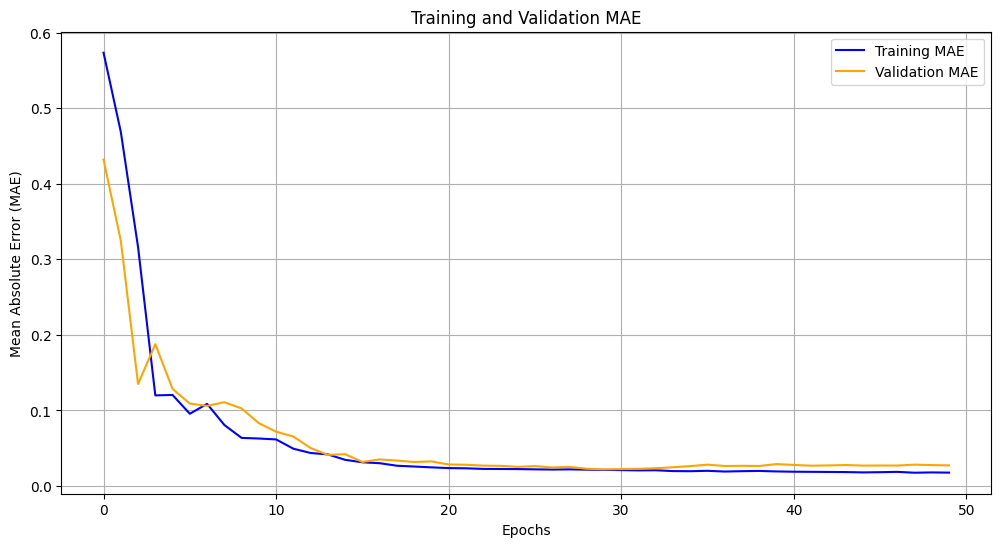

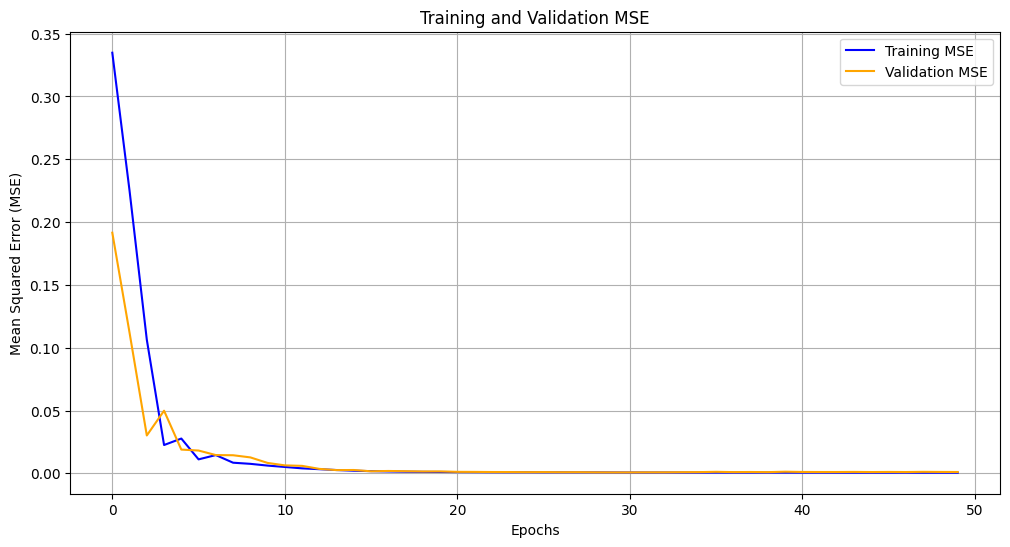

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Mean Absolute Error (MAE): 0.017
Mean Squared Error (MSE): 0.000
R^2 Score: 0.908
Mean Absolute Percentage Error (MAPE): 12.799%


In [52]:
history = base_lstm_history.history

train_mae, train_mse = history['mae'], history['mse']
validate_mae, validate_mse = history['val_mae'], history['val_mse']


plot_train_val_evaluation_history(train_mae, validate_mae, "MAE")
plot_train_val_evaluation_history(train_mse, validate_mse, "MSE")

# Get model predictions on Test Data
y_pred = lstm_base_model.predict(test_feature_seq)
y_true = pd.DataFrame(test_target_seq)

# Print Evaluation Metrics
base_lstm_metric =  print_evaluation_metrics(y_true, y_pred)

### 4.4 Hyper-tune LSTM

In [53]:
import keras_tuner as kt # type: ignore

TIME_STEP = 3

def build_model(hp):
    model = keras.Sequential()


    # Adding LSTM layers
    for i in range(4):  # 3 LSTM layers
        model.add(layers.LSTM(
            units=hp.Int(f'units_{i}', min_value=32, max_value=128, step=32),
            input_shape=(train_feature_seq.shape[1], train_feature_seq.shape[2]) if i == 0 else None,
            activation="relu",
            return_sequences=i < 3,
        ))

    # Output layer
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(1))

    # Tuning learning rate

    model.compile(
        optimizer='adam',
        loss='mae',
        metrics=['mae', 'mse']
    )

    return model

tuner = kt.Hyperband(
    build_model,
    objective='val_mae',
    max_epochs=25,
    factor=12,
    directory='nn_cache',
    project_name='LSTM_tuning',
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=4,
    restore_best_weights=True,
    monitor='val_mae'
)

# Hyperparameter search
tuner.search(
    train_feature_seq, train_target_seq,
    epochs=100,
    callbacks=[early_stopping],
    validation_data=(validation_feature_seq, validation_target_seq),
    batch_size=12,
    verbose=1
)

# Get best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Reloading Tuner from nn_cache/LSTM_tuning/tuner0.json


### 4.5 Build Hyper-tuned LSTM Model

In [54]:
lstm_model = tuner.hypermodel.build(best_hps)
lstm_model.compile(optimizer='adam', loss='mae', metrics=['mae', 'mse'])
# Train final model
lstm_model.summary()
lstm_history = lstm_model.fit(
    train_feature_seq, train_target_seq,
    epochs=100,
    batch_size=16,
    validation_data=(validation_feature_seq, validation_target_seq),
)

/Users/mac/Desktop/kingston/Deep-learning-assignment/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 7, 96)          │        39,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 7, 96)          │        74,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 7, 128)         │       115,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 360,961 (1.38 MB)

 Trainable params: 360,961 (1.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.3839 - mae: 0.3839 - mse: 0.2223 - val_loss: 0.0757 - val_mae: 0.0757 - val_mse: 0.0071
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0925 - mae: 0.0925 - mse: 0.0141 - val_loss: 0.0831 - val_mae: 0.0831 - val_mse: 0.0080
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0787 - mae: 0.0787 - mse: 0.0106 - val_loss: 0.0264 - val_mae: 0.0264 - val_mse: 0.0011
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0583 - mae: 0.0583 - mse: 0.0057 - val_loss: 0.0867 - val_mae: 0.0867 - val_mse: 0.0084
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0836 - mae: 0.0836 - mse: 0.0111 - val_loss: 0.0232 - val_mae: 0.0232 - val_mse: 9.1586e-04
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0540 - mae: 0.0540 - mse: 0.0048 - val_loss: 0.0416 - val_mae: 0.0416 - val_mse: 0.0022
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0590 - mae: 0.0590 - mse: 0.0056 -

### 4.6 Evaluate the Hyper-tuned Data 

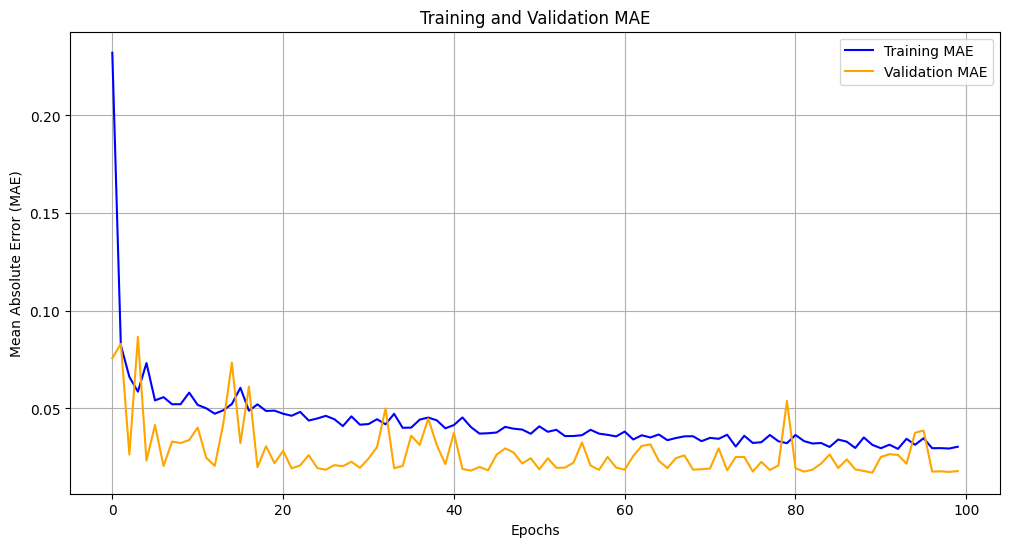

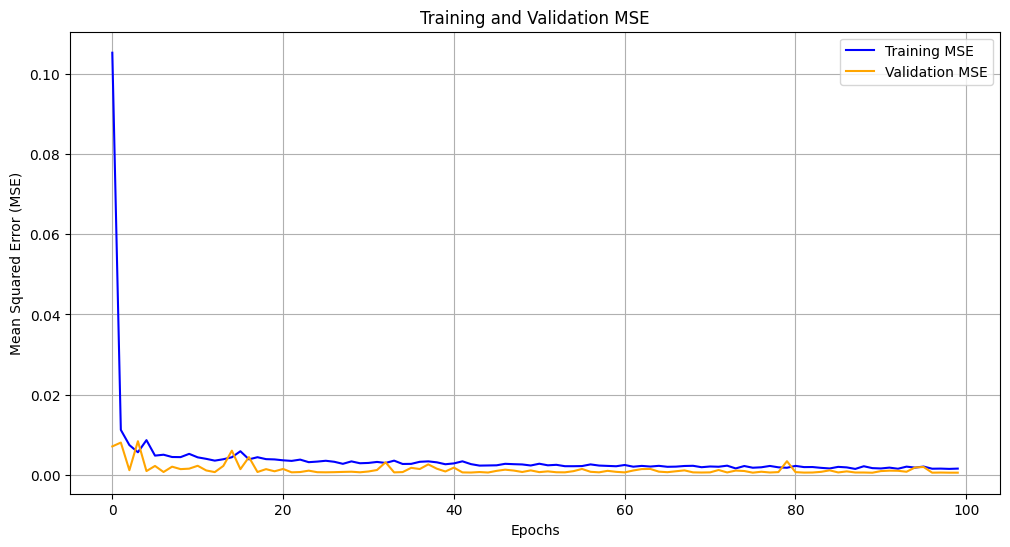

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mean Absolute Error (MAE): 0.020
Mean Squared Error (MSE): 0.001
R^2 Score: 0.847
Mean Absolute Percentage Error (MAPE): 12.461%


In [55]:
history = lstm_history.history

train_mae, train_mse = history['mae'], history['mse']
validate_mae, validate_mse = history['val_mae'], history['val_mse']

plot_train_val_evaluation_history(train_mae, validate_mae, "MAE")
plot_train_val_evaluation_history(train_mse, validate_mse, "MSE")

# Get model predictions on Test Data
y_pred = lstm_model.predict(test_feature_seq)
y_true = pd.DataFrame(test_target_seq)

# Print Evaluation Metrics
lstm_metric =  print_evaluation_metrics(y_true, y_pred)

lstm_pred = target_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))

### 4.7 Plot the Actual, Predicted Value 

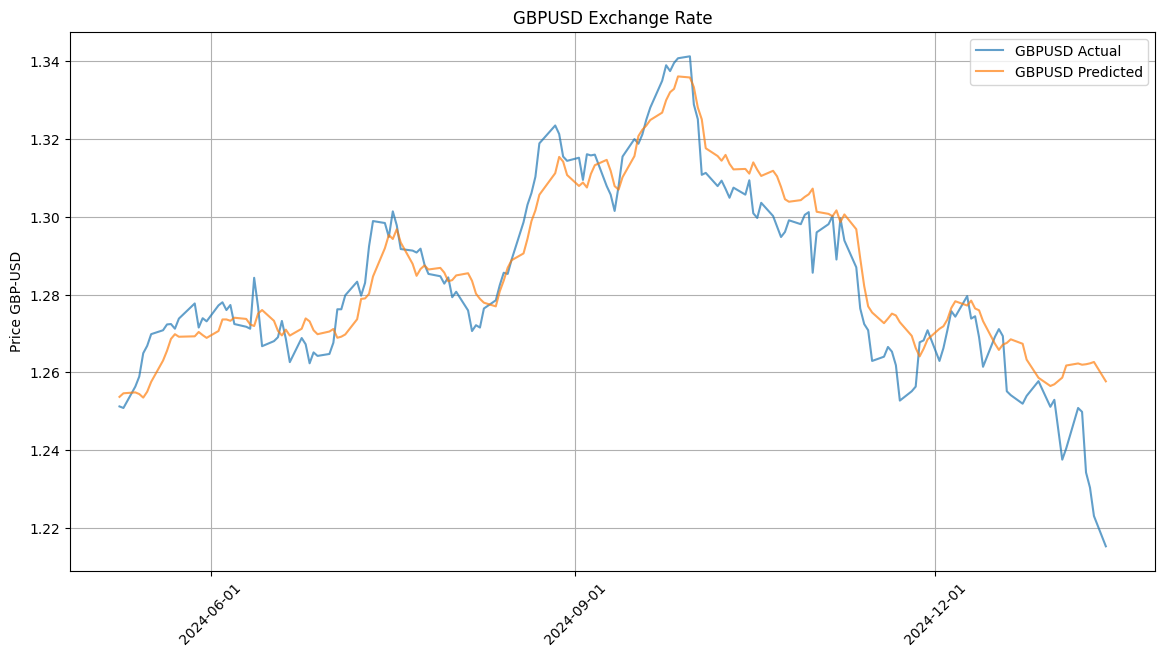

In [56]:
y_pred_unscaled = target_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))
y_test_unscaled = u_test[target].values[7:]

actual_data = [test["Date"][7:], y_test_unscaled, "GBPUSD Actual"]
predicted_data = [test["Date"][7:], y_pred_unscaled, "GBPUSD Predicted"]

lstm_pred = y_pred_unscaled

plot_gbp_usd([actual_data, predicted_data])

# 5. Recurrent Model (Time Series)

### 5.1 Build base model

In [57]:
rnn_base_model = Sequential()
rnn_base_model.add(layers.SimpleRNN(units=64, activation='relu', input_shape=(train_feature_seq.shape[1], train_feature_seq.shape[2])))
rnn_base_model.add(layers.Dense(1))
    
rnn_base_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

rnn_base_model.summary()

rnn_base_history = rnn_base_model.fit(train_feature_seq, train_target_seq, epochs=50, batch_size=32, validation_data=(validation_feature_seq, validation_target_seq))

/Users/mac/Desktop/kingston/Deep-learning-assignment/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 64)             │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,673 (18.25 KB)

 Trainable params: 4,673 (18.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1229 - mae: 0.2658 - mse: 0.1229 - val_loss: 0.0076 - val_mae: 0.0721 - val_mse: 0.0076
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0098 - mae: 0.0788 - mse: 0.0098 - val_loss: 0.0045 - val_mae: 0.0523 - val_mse: 0.0045
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044 - mae: 0.0522 - mse: 0.0044 - val_loss: 0.0022 - val_mae: 0.0357 - val_mse: 0.0022
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028 - mae: 0.0414 - mse: 0.0028 - val_loss: 0.0015 - val_mae: 0.0292 - val_mse: 0.0015
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028 - mae: 0.0427 - mse: 0.0028 - val_loss: 0.0014 - val_mae: 0.0296 - val_mse: 0.0014
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 - mae: 0.0297 - mse: 0.0014 - val_loss: 0.0013 - val_mae: 0.0283 - val_mse: 0.0013
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015 - mae: 0.0315 - mse: 0.0015 - val_loss: 0.0010 

### 5.2 Evaluate base model 

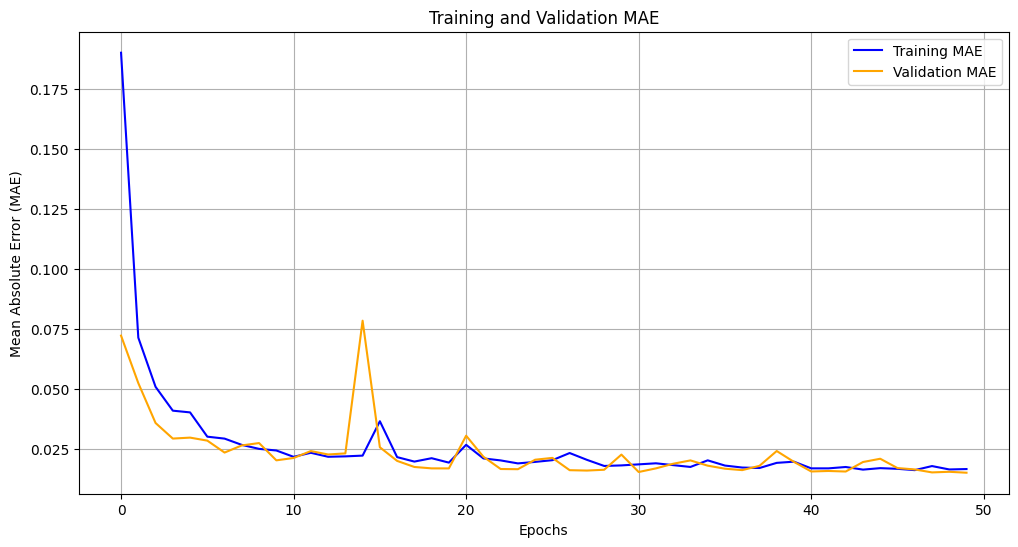

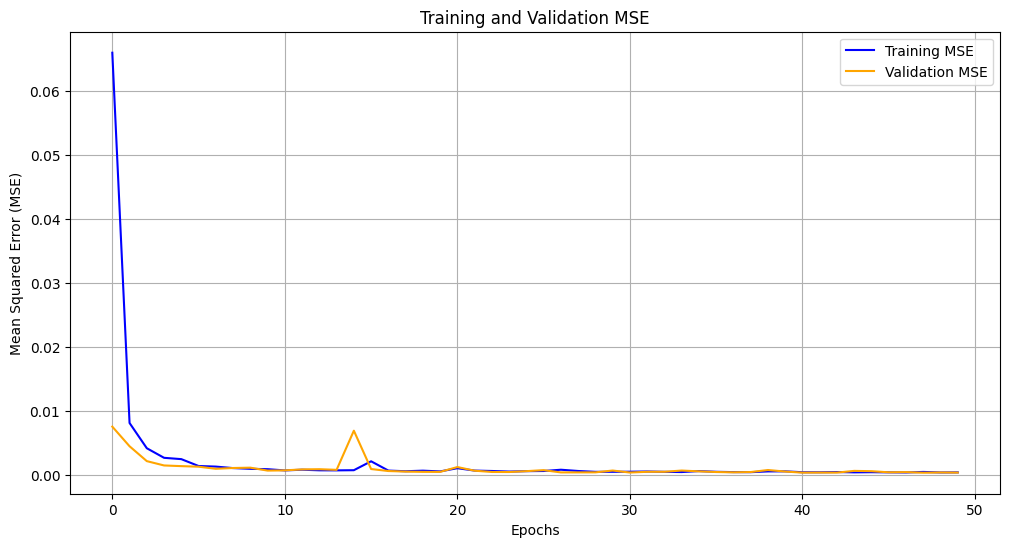

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Mean Absolute Error (MAE): 0.016
Mean Squared Error (MSE): 0.000
R^2 Score: 0.897
Mean Absolute Percentage Error (MAPE): 12.641%


In [58]:
history = rnn_base_history.history

train_mae, train_mse = history['mae'], history['mse']
validate_mae, validate_mse = history['val_mae'], history['val_mse']

plot_train_val_evaluation_history(train_mae, validate_mae, "MAE")
plot_train_val_evaluation_history(train_mse, validate_mse, "MSE")

# Get model predictions on Test Data
y_pred = rnn_base_model.predict(test_feature_seq)
y_true = pd.DataFrame(test_target_seq)

# Print Evaluation Metrics
rnn_base_metric = print_evaluation_metrics(y_true, y_pred)

### 5.3 Hyper-tune RNN model

In [59]:
# Build RNN model
def build_model(hp):
	model = Sequential()
	num_layers = hp.Int('num_layers', min_value=1, max_value=4)
	for i in range(num_layers):
		model.add(layers.SimpleRNN(
			units=hp.Int(f'units_{i}', min_value=16, max_value=62, step=16),
			activation='relu',
			return_sequences=(i != num_layers - 1),
			input_shape=(train_feature_seq.shape[1], train_feature_seq.shape[2]) if i == 0 else None
		))
		model.add(layers.Dropout(0.1))
	
	model.add(layers.Dense(units=1))  # Output layer

	model.compile(
		optimizer=tf.keras.optimizers.Adam(
			learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
		),
		loss='mean_squared_error',
		metrics=['mae', 'mse']
	)
	return model

# Hyperband tuner
tuner = kt.Hyperband(
	build_model,
	objective='val_loss',
	max_epochs=25,
	factor=3,
	directory='nn_cache',
	project_name='RNN'
)

# Search for the best hyperparameters
tuner.search(train_feature_seq, train_target_seq, epochs=50, validation_data=(validation_feature_seq, validation_target_seq), batch_size=32)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

Reloading Tuner from nn_cache/RNN/tuner0.json


{'num_layers': 1,
 'units_0': 32,
 'learning_rate': 0.008657014016556722,
 'units_1': 48,
 'units_2': 48,
 'units_3': 32,
 'tuner/epochs': 25,
 'tuner/initial_epoch': 9,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0021'}

### 5.4 Build Hyper-tune model 

In [60]:
rnn_model = tuner.hypermodel.build(best_hps)
rnn_model.compile(optimizer='adam', loss='mae', metrics=['mae', 'mse'])
rnn_model.summary()
# Train final model
rnn_history = rnn_model.fit(
    train_feature_seq, train_target_seq,
    epochs=100,
    batch_size=50,
    validation_data=(validation_feature_seq, validation_target_seq),
)

/Users/mac/Desktop/kingston/Deep-learning-assignment/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_3 (SimpleRNN)        │ (None, 32)             │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,313 (5.13 KB)

 Trainable params: 1,313 (5.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9580 - mae: 0.9580 - mse: 1.1176 - val_loss: 0.1895 - val_mae: 0.1895 - val_mse: 0.0495
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2704 - mae: 0.2704 - mse: 0.1185 - val_loss: 0.1550 - val_mae: 0.1550 - val_mse: 0.0341
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2177 - mae: 0.2177 - mse: 0.0789 - val_loss: 0.1033 - val_mae: 0.1033 - val_mse: 0.0162
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1936 - mae: 0.1936 - mse: 0.0651 - val_loss: 0.0869 - val_mae: 0.0869 - val_mse: 0.0115
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1751 - mae: 0.1751 - mse: 0.0553 - val_loss: 0.0787 - val_mae: 0.0787 - val_mse: 0.0095
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1519 - mae: 0.1519 - mse: 0.0394 - val_loss: 0.0822 - val_mae: 0.0822 - val_mse: 0.0103
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1477 - mae: 0.1477 - mse: 0.0438 - val_loss:

### 5.4 Evaluate Hyper-tuned model

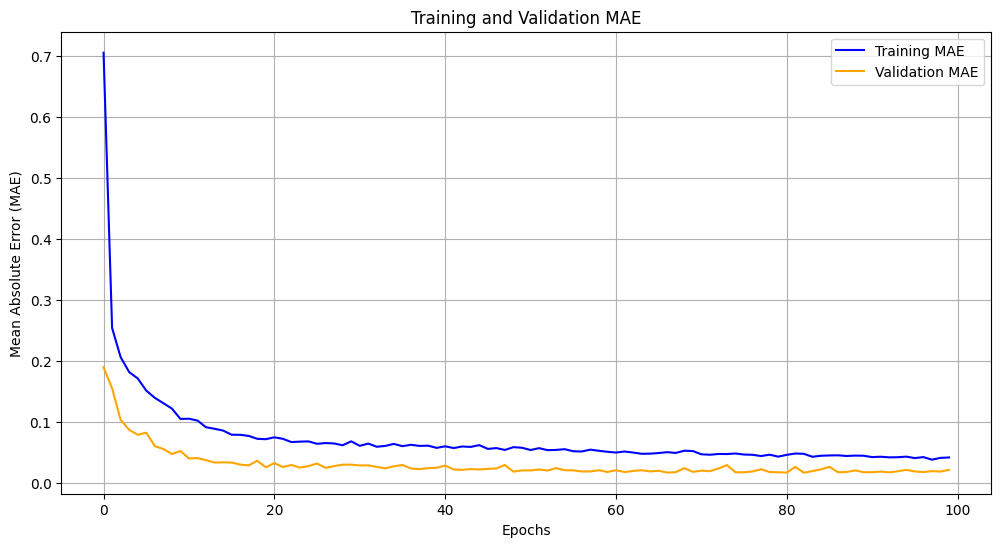

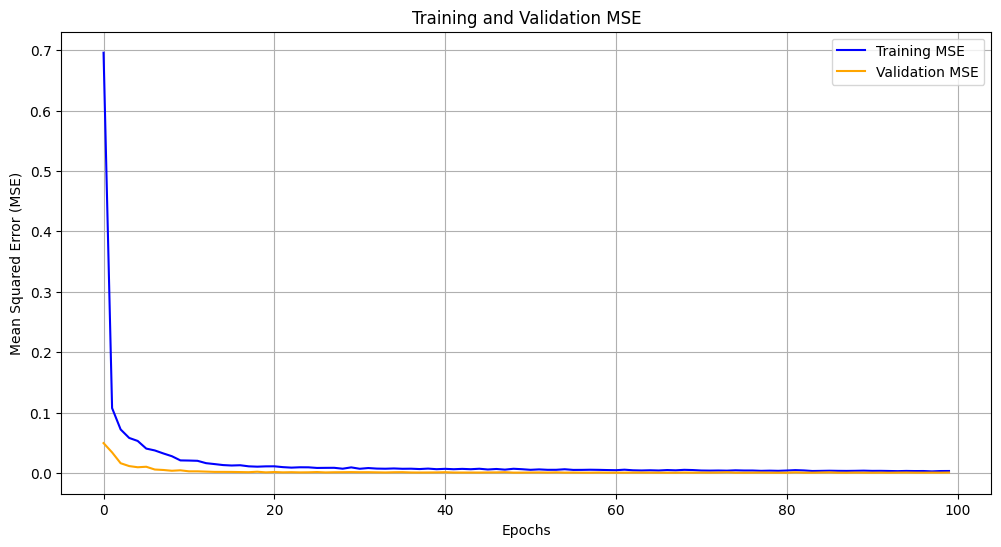

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Mean Absolute Error (MAE): 0.020
Mean Squared Error (MSE): 0.001
R^2 Score: 0.842
Mean Absolute Percentage Error (MAPE): 12.627%


In [61]:
history = rnn_history.history

train_mae, train_mse = history['mae'], history['mse']
validate_mae, validate_mse = history['val_mae'], history['val_mse']


plot_train_val_evaluation_history(train_mae, validate_mae, "MAE")
plot_train_val_evaluation_history(train_mse, validate_mse, "MSE")

# Get model predictions on Test Data
y_pred = rnn_model.predict(test_feature_seq)
y_true = pd.DataFrame(test_target_seq)

# Print Evaluation Metrics
rnn_metric =  print_evaluation_metrics(y_true, y_pred)


rnn_pred = target_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))

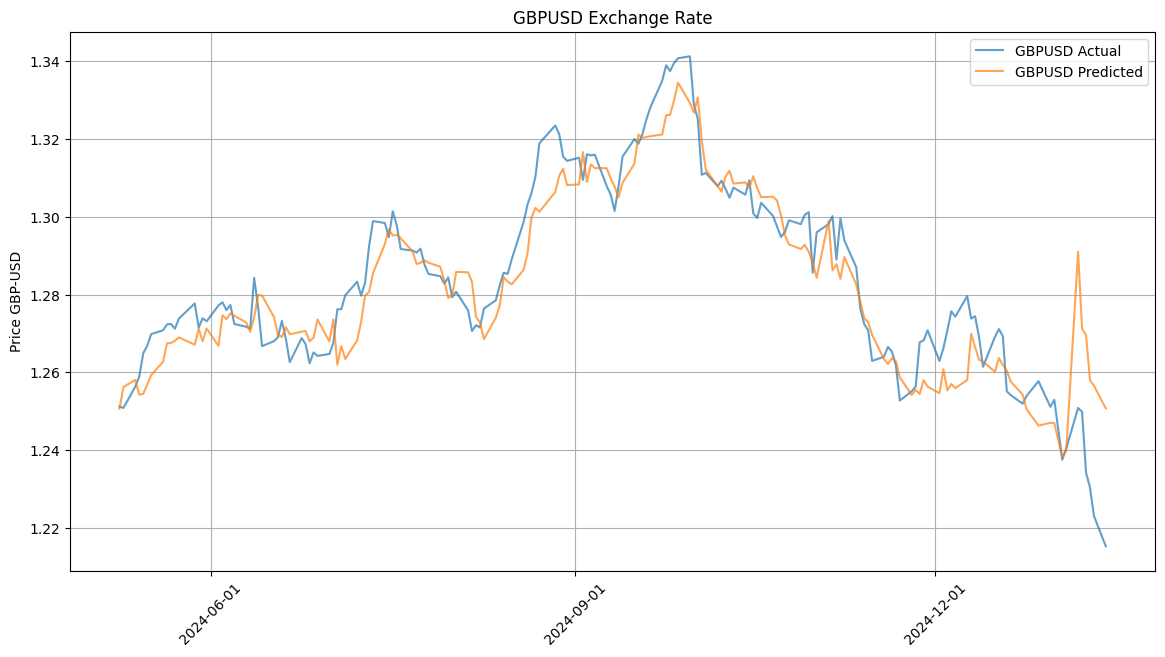

In [62]:
y_pred_unscaled = target_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))
y_test_unscaled = u_test[target].values[7:]

actual_data = [test["Date"][7:], y_test_unscaled, "GBPUSD Actual"]
predicted_data = [test["Date"][7:], y_pred_unscaled, "GBPUSD Predicted"]

rnn_pred = y_pred_unscaled

plot_gbp_usd([actual_data, predicted_data])

# 6. CNN_LSTM Model (Regression)

### 6.1 Develop Base Model

In [63]:
cl_base_model = keras.Sequential()

cl_base_model.add(layers.Input(shape=(train_feature_seq.shape[1], train_feature_seq.shape[2])))
cl_base_model.add(layers.Conv1D(filters=32, kernel_size=3, activation='relu'))
cl_base_model.add(layers.LSTM(units=64, return_sequences=False))
cl_base_model.add(layers.Dense(units=1, activation='linear'))
cl_base_model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

cl_base_history = cl_base_model.fit(train_feature_seq, train_target_seq, epochs=50, batch_size=32, validation_data=(validation_feature_seq, validation_target_seq))

cl_base_model.summary()


Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2618 - mae: 0.4246 - mse: 0.2618 - val_loss: 0.0047 - val_mae: 0.0564 - val_mse: 0.0047
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0172 - mae: 0.1072 - mse: 0.0172 - val_loss: 0.0073 - val_mae: 0.0728 - val_mse: 0.0073
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0054 - mae: 0.0582 - mse: 0.0054 - val_loss: 0.0020 - val_mae: 0.0374 - val_mse: 0.0020
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 - mae: 0.0367 - mse: 0.0021 - val_loss: 7.5721e-04 - val_mae: 0.0216 - val_mse: 7.5721e-04
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - mae: 0.0269 - mse: 0.0012 - val_loss: 6.8773e-04 - val_mae: 0.0203 - val_mse: 6.8773e-04
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 - mae: 0.0274 - mse: 0.0013 - val_loss: 5.0344e-04 - val_mae: 0.0177 - val_mse: 5.0344e-04
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.5855e-04 - mae: 0.0239 - mse

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 5, 32)          │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,805 (300.02 KB)

 Trainable params: 25,601 (100.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 51,204 (200.02 KB)

### 6.2 Evaluate Base Model

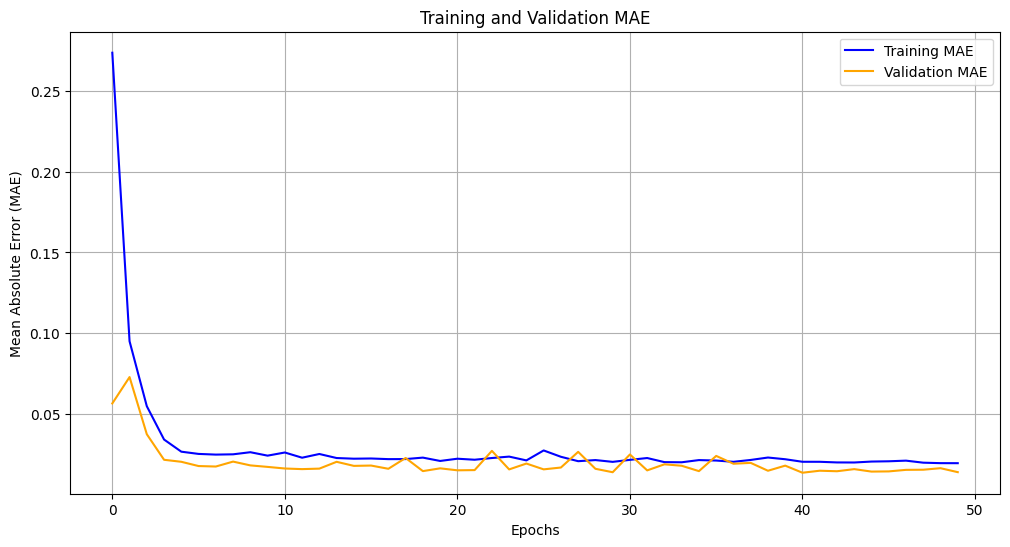

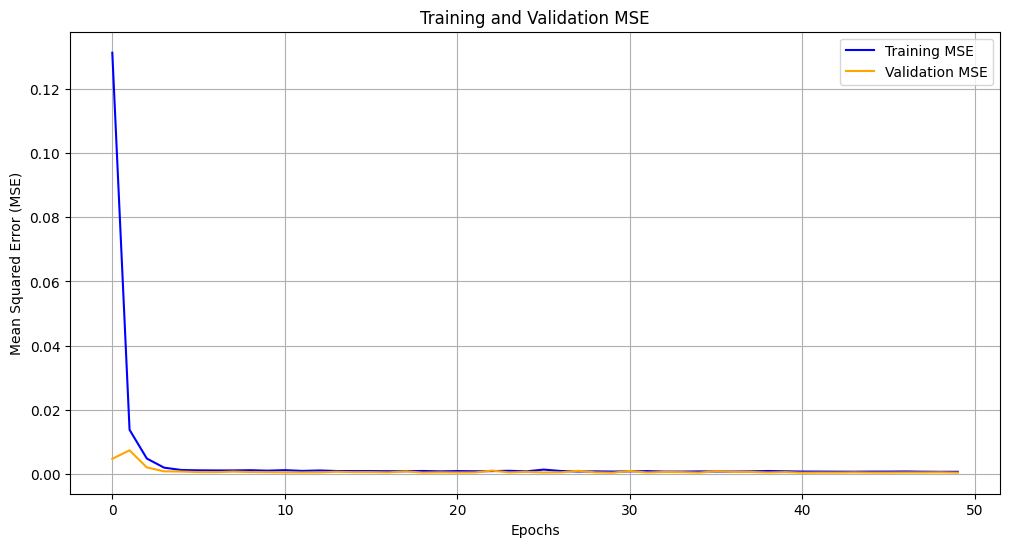

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Mean Absolute Error (MAE): 0.017
Mean Squared Error (MSE): 0.001
R^2 Score: 0.896
Mean Absolute Percentage Error (MAPE): 12.468%


In [64]:
history = cl_base_history.history
train_mae, train_mse = history['mae'], history['mse']
validate_mae, validate_mse = history['val_mae'], history['val_mse']


plot_train_val_evaluation_history(train_mae, validate_mae, "MAE")
plot_train_val_evaluation_history(train_mse, validate_mse, "MSE")

# Get model predictions on Test Data
y_pred = cl_base_model.predict(test_feature_seq)
y_true = pd.DataFrame(test_target_seq)

# Print Evaluation Metrics
cl_base_metric =  print_evaluation_metrics(y_true, y_pred)

### 6.3 Hyper-tune model

In [65]:
# Define LSTM-CNN Model with hyper-tuning for the number of layers
def build_lstm_cnn_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(train_feature_seq.shape[1], train_feature_seq.shape[2])))
    
    for i in range(hp.Int('num_cnn_layers', 1, 2)):
        model.add(layers.Conv1D(
            filters=hp.Int(f'cnn_filters_{i}', min_value=50, max_value=100, step=25),
            kernel_size=hp.Choice(f'cnn_kernel_size_{i}', values=[1, 2]),
            activation='relu'
        ))
    
    # Hyper-tuning number of LSTM layers
    for i in range(hp.Int('num_lstm_layers', 1, 2)):
        model.add(layers.LSTM(
            units=hp.Int(f'lstm_units_{i}', min_value=32, max_value=64, step=8),
            return_sequences=True if i < hp.get('num_lstm_layers') - 1 else False
        ))
        model.add(layers.Dropout(hp.Float('dropout_rate', 0.1, 0.2, step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    
    # Compile the model
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae', 'mse']
    )
    return model

# Hyperband tuner
tuner = kt.Hyperband(
    build_lstm_cnn_model,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory='nn_cache',
    project_name='lstm_cnn'
)

# Run Hyperband tuning
tuner.search(train_feature_seq, train_target_seq, validation_data=(validation_feature_seq, validation_target_seq), epochs=50, batch_size=32)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Reloading Tuner from nn_cache/lstm_cnn/tuner0.json


In [66]:
lc_model = tuner.hypermodel.build(best_hps)
lc_model.compile(optimizer='adam', loss='mae', metrics=['mae', 'mse'])

# Train final model
lc_history = lc_model.fit(
    train_feature_seq, train_target_seq,
    epochs=200,
    batch_size=16,
    validation_data=(validation_feature_seq, validation_target_seq),
)

lc_model.summary()

Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1598 - mae: 0.1598 - mse: 0.0613 - val_loss: 0.0475 - val_mae: 0.0475 - val_mse: 0.0028
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0586 - mae: 0.0586 - mse: 0.0057 - val_loss: 0.0188 - val_mae: 0.0188 - val_mse: 6.2079e-04
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0407 - mae: 0.0407 - mse: 0.0027 - val_loss: 0.0304 - val_mae: 0.0304 - val_mse: 0.0014
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0425 - mae: 0.0425 - mse: 0.0029 - val_loss: 0.0400 - val_mae: 0.0400 - val_mse: 0.0020
Epoch 5/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0461 - mae: 0.0461 - mse: 0.0033 - val_loss: 0.0214 - val_mae: 0.0214 - val_mse: 6.9943e-04
Epoch 6/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0358 - mae: 0.0358 - mse: 0.0020 - val_loss: 0.0152 - val_mae: 0.0152 - val_mse: 3.9065e-04
Epoch 7/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0365 - mae: 0.0365 - mse: 0.0021 

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 6, 100)         │         1,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 6, 75)          │         7,575 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 56)             │        29,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 56)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            57 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,102 (453.53 KB)

 Trainable params: 38,700 (151.17 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 77,402 (302.36 KB)

### 6.4 Evaluate the Hyper-tuned model

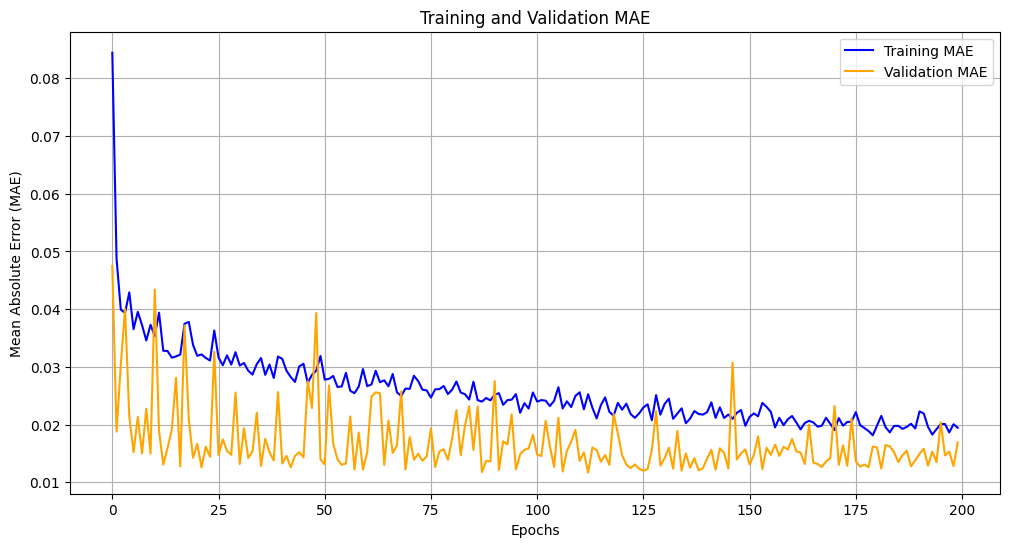

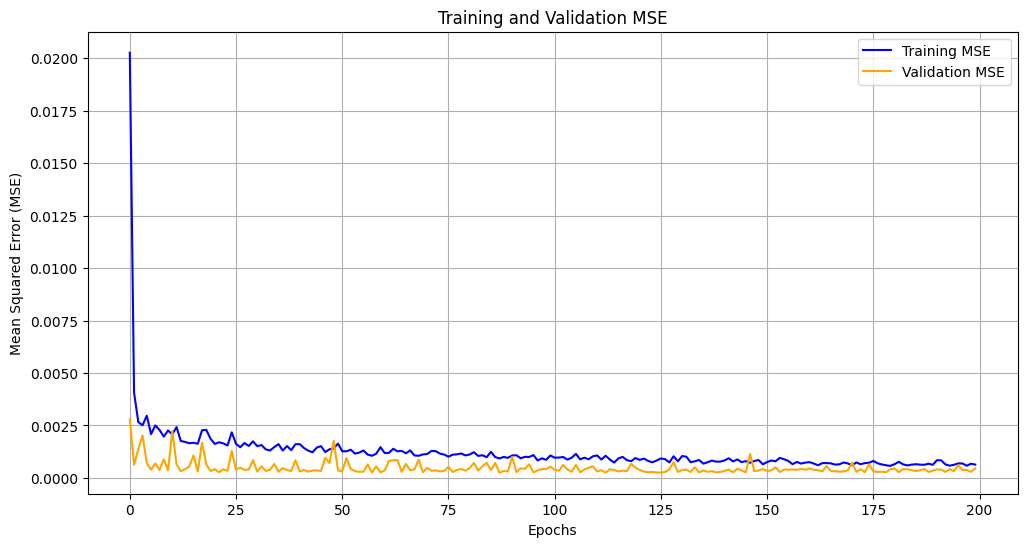

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Mean Absolute Error (MAE): 0.021
Mean Squared Error (MSE): 0.001
R^2 Score: 0.843
Mean Absolute Percentage Error (MAPE): 13.332%


In [67]:
def evaluate_model(history, model, test_features, test_target):
	# Extract training and validation metrics
	train_mae, train_mse = history['mae'], history['mse']
	validate_mae, validate_mse = history['val_mae'], history['val_mse']

	# Plot the training and validation MAE and MSE
	plot_train_val_evaluation_history(train_mae, validate_mae, "MAE")
	plot_train_val_evaluation_history(train_mse, validate_mse, "MSE")

	# Get model predictions on Test Data
	y_pred = model.predict(test_features)
	y_true = pd.DataFrame(test_target)

	# Print Evaluation Metrics
	metric  = print_evaluation_metrics(y_true, y_pred)

	return metric, y_pred

lc_metric, y_pred =  evaluate_model(lc_history.history, lc_model, test_feature_seq, test_target_seq)
lc_pred = target_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))


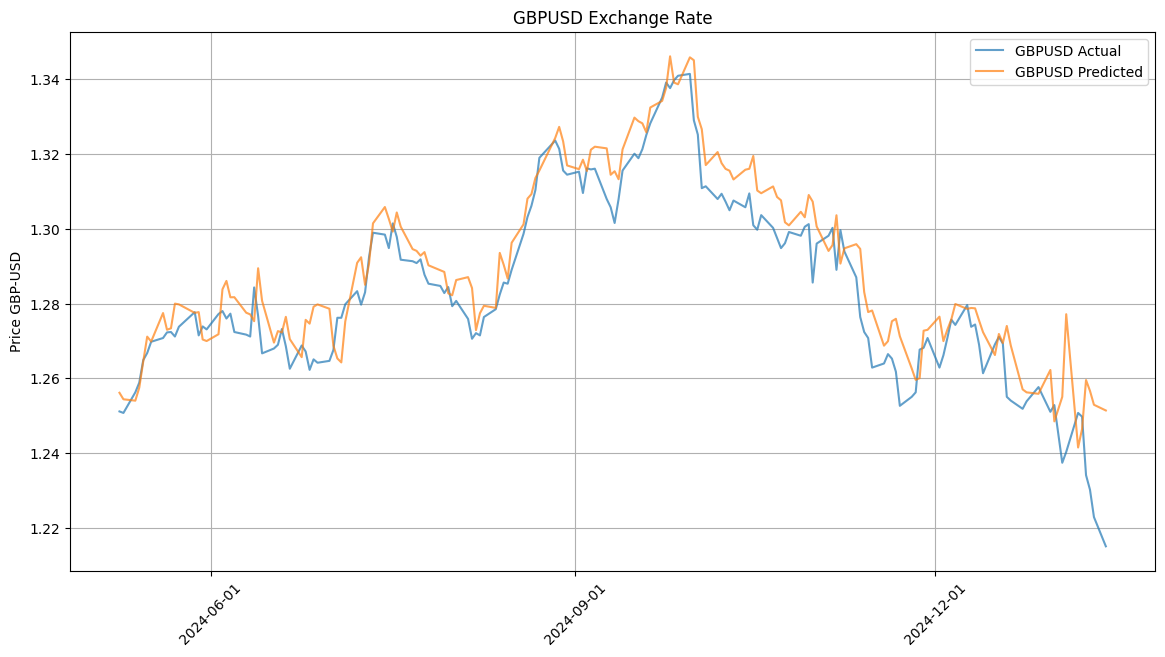

In [68]:
y_pred_unscaled = target_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))
y_test_unscaled = u_test[target].values[7:]

actual_data = [test["Date"][7:], y_test_unscaled, "GBPUSD Actual"]
predicted_data = [test["Date"][7:], y_pred_unscaled, "GBPUSD Predicted"]

lc_pred = y_pred_unscaled

plot_gbp_usd([actual_data, predicted_data])

# Plot all metrics in a single table

In [69]:
metrics = [[dnn_base_metric, "DNN base model"], [dnn_metric, "DNN Hyper-tuned model" ],[base_lstm_metric, "LSTM base model"], [lstm_metric, "LSTM metric" ],[rnn_base_metric, "RNN base model"], [rnn_metric, "RNN Hyper-tuned model"], [cl_base_metric, "Ensemble base metric"], [lc_metric, "Ensemble Hyper-tuned model"]]  

df = pd.DataFrame()
# Initialize the DataFrame with appropriate columns
df = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'R Square', 'MAPE'])

# Populate the DataFrame with metrics
for i, m in enumerate(metrics):
	df = pd.concat([df, pd.DataFrame([{
		'Model': m[1],
		'MAE': round(m[0]['MAE'], 5),
		'MSE': round(m[0]['MSE'], 5),
		'R Square': round(m[0]['R Square'], 5),
		'MAPE': round(m[0]['MAPE'], 5)
	}])], ignore_index=True)

df
        

/var/folders/xz/1gn0m18n5k1bjmbt205k50cm0000gn/T/ipykernel_7349/3625100056.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([{


,Model,MAE,MSE,R Square,MAPE
0,DNN base model,0.00147,0.00000,0.99921,0.11556
1,DNN Hyper-tuned model,0.01122,0.00067,0.86484,2.15072
2,LSTM base model,0.01736,0.00045,0.90785,12.79864
3,LSTM metric,0.02028,0.00074,0.84729,12.46056
4,RNN base model,0.01615,0.00050,0.89740,12.64115
5,RNN Hyper-tuned model,0.01996,0.00077,0.84184,12.62682
6,Ensemble base metric,0.01709,0.00051,0.89565,12.46812
7,Ensemble Hyper-tuned model,0.02094,0.00076,0.84284,13.33181


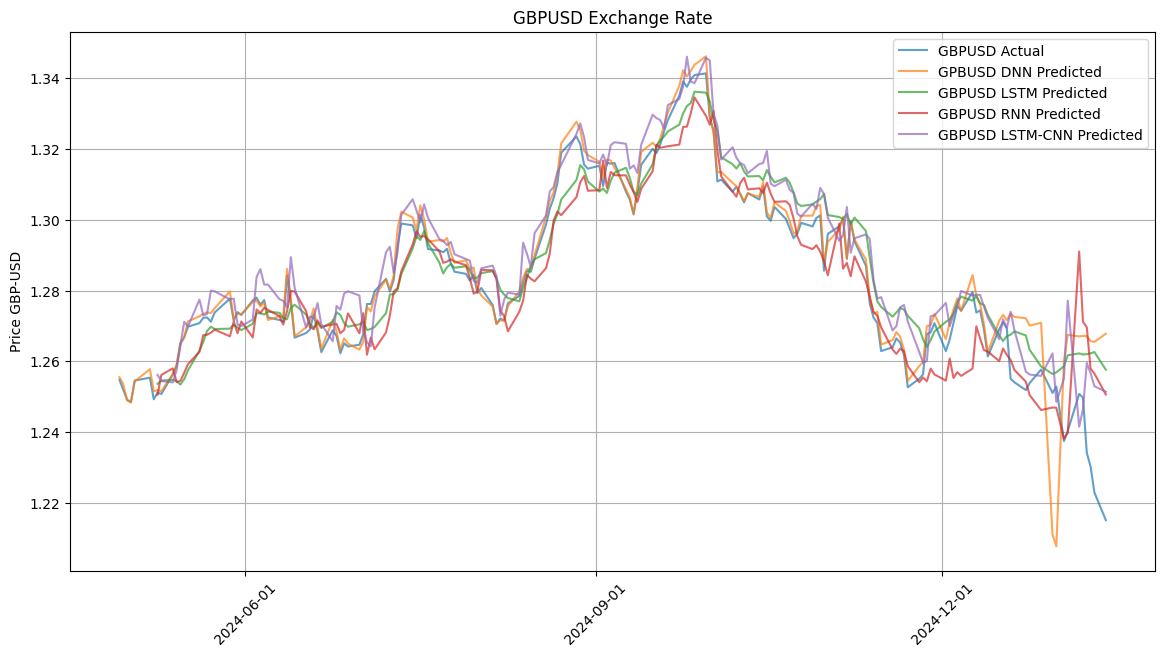

In [71]:
dnn_features = ['Trend', 'Seasonality', 'Noise', 'Week', 'Month', 'Day', 'Open']

plot_gbp_usd([
	[test['Date'], u_test['Open'], "GBPUSD Actual"],
	[test['Date'], dnn_predicted, "GPBUSD DNN Predicted"],
	[test['Date'][7:], lstm_pred, "GBPUSD LSTM Predicted"],
	[test['Date'][7:], rnn_pred, "GBPUSD RNN Predicted"],
	[test['Date'][7:], lc_pred, "GBPUSD LSTM-CNN Predicted"],
])
